# Web Stable Diffusion

This project brings stable diffusion models to web browsers. **Everything runs inside the browser with no server support.** To our knowledge, this is the the world’s first stable diffusion completely running on the browser. This notebook is a walk-through on the entire pipeline, including how to import the stable diffusion models from Hugging Face and PyTorch, how to optimize and build the model locally, and how to deploy it to native GPU runtime and WebGPU runtime. Now let’s get started.

## Install packages

To import and build the model, we first need to install the on-going development of TVM Unity and other dependencies with the following pip command.  

In [1]:
!python3 -m pip install --pre torch --upgrade --index-url https://download.pytorch.org/whl/nightly/cpu
!python3 -m pip install -r requirements.txt

import GPUtil
has_gpu = len(GPUtil.getGPUs()) > 0
cudav = "-cu116" if has_gpu else "" # check https://mlc.ai/wheels if you have a different CUDA version

!python3 -m pip install mlc-ai-nightly{cudav} -f https://mlc.ai/wheels

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 MB 116.4 MB/s eta 0:00:0000:0100:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 35.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 124.6 MB/s eta 0:00:00a 0:00:01
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=3665fc6eefafef230d752cc8456b2616b6570b3a2a800bd1c70a6a9087a97ee2
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hr20ajd/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in links: https://mlc.ai/wheels
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

We import necessary packages and set up the artifact directory.

In [2]:
from typing import Dict, List, Tuple
from platform import system

import tvm
from tvm import relax

torch_dev_key = "cpu"

if system() == "Darwin":
    target = tvm.target.Target("apple/m1-gpu")
    device = tvm.metal()
else:
    target = tvm.target.Target("cuda" if has_gpu else "llvm")
    device = tvm.cuda() if has_gpu else tvm.cpu()

In [3]:
!mkdir -p dist

## Import stable diffusion models

With necessary packages imported, the first step is to import the stable diffusion PyTorch models into TVM. A standard text-to-image stable diffusion pipeline consists of four stages:
* A text tokenizer which converts the input text prompts to tokens.
* A text encoder (CLIP) which encodes the tokenized text prompts to text embeddings.
* A denoising model (UNet) which denoises a random initial latents for a certain number of steps, guided by the encoded text.
* An image decoder (VAE) which decodes the final latents to an image.

We shall import these models from PyTorch to TVM. As in Web Stable Diffusion we leverage the [wasm port](https://blog.mithrilsecurity.io/porting-tokenizers-to-wasm/) of the Hugging Face [tokenizers library](https://github.com/huggingface/tokenizers), we only need to import the rest three models: CLIP, UNet and VAE.

PyTorch provides [TorchDynamo](https://pytorch.org/tutorials/intermediate/dynamo_tutorial.html) that can capture the computational graph of a torch model and represent the graph in [Torch FX](https://pytorch.org/docs/stable/fx.html), torch’s graph-level intermediate representation (IR) of a model. TorchDynamo and FX are the tools we leverage. More specifically, we first use TorchDynamo to capture the model’s execution into an FX GraphModule, and then translate the FX GraphModule to a Relax function -- the graph-level IR of TVM Unity.

Firstly, let’s fetch the pre-trained [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5) pipeline, which contains the all the models we will import.

In [4]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

/home/ganler/miniconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 40800.62it/s]
/home/ganler/miniconda3/envs/test/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


We take the import of the CLIP model as an example. To use TorchDynamo and FX, we first define a wrapper `torch.nn.Module` that contains the CLIP model, and construct an instance of the wrapper.

In [5]:
import torch

# Define the wrapper torch.nn.Module for CLIP.
class CLIPModelWrapper(torch.nn.Module):
    def __init__(self, clip):
        super().__init__()
        self.clip = clip

    def forward(self, text_input_ids):
        text_embeddings = self.clip(text_input_ids)[0]
        return text_embeddings
    
clip = pipe.text_encoder
clip_to_text_embeddings = CLIPModelWrapper(clip)

Relax has provided a helper function `dynamo_capture_subgraphs`, which uses TorchDynamo to capture the computational graph, and translate the captured FX GraphModule to a Relax function. In stable diffusion, the maximum length of text prompts is 77. So the input to the CLIP model has length 77. We create a random input as the simulation of tokenized text prompt, and pass it to the wrapper for TorchDynamo capture.

In [6]:
from tvm.relax.frontend.torch import dynamo_capture_subgraphs

# Create random input.
text_input_ids = torch.rand((1, 77)).to(torch.int32)
# Capture CLIP's computational graph.
mod: tvm.IRModule = dynamo_capture_subgraphs(
    clip_to_text_embeddings.forward,
    text_input_ids,
    keep_params_as_input=True,
)

We get an IRModule from `dynamo_capture_subgraphs`. This IRModule contains the computational graph of the CLIP model, as well as the weight parameters of the CLIP model. We can use `detach_params` provided by Relax to separate the captured computational graph and the weight parameters.

In [7]:
mod, params = relax.frontend.detach_params(mod)

We can try to print out the IRModule via 
```python
mod.show()
```
to see the CLIP model we have captured in the IRModule. The output will be hundreds of lines long, so we do not run it live here. If you try it out, the printed output should look in the following way:
```python
# from tvm.script import ir as I
# from tvm.script import relax as R

@I.ir_module
class Module:
    @R.function
    def subgraph_0(
        inp_0: R.Tensor((1, 77), dtype="int32"),
        self_clip_text_model_embeddings_position_embedding_weight: R.Tensor((77, 768), dtype="float32"),
        self_clip_text_model_embeddings_token_embedding_weight: R.Tensor((49408, 768), dtype="float32"),
        ...
    ) -> R.Tensor((1, 77, 768), dtype="float32"):
        R.func_attr({"num_input": 1})
        with R.dataflow():
            lv: R.Tensor((1, 77), dtype="int32") = R.reshape(inp_0, R.shape([1, 77]))
            lv1: R.Tensor((1, 77), dtype="int32") = R.astype(lv, dtype="int32")
            lv2: R.Tensor((77,), dtype="int32") = R.reshape(lv1, R.shape([77]))
            lv3: R.Tensor((77, 768), dtype="float32") = R.take(self_clip_text_model_embeddings_token_embedding_weight, lv2, axis=0)
            lv4: R.Tensor((1, 77, 768), dtype="float32") = R.reshape(lv3, R.shape([1, 77, 768]))
            lv5: R.Tensor((1, 77), dtype="int32") = R.astype(metadata["relax.expr.Constant"][0], dtype="int32")
            lv6: R.Tensor((77,), dtype="int32") = R.reshape(lv5, R.shape([77]))
            lv7: R.Tensor((77, 768), dtype="float32") = R.take(self_clip_text_model_embeddings_position_embedding_weight, lv6, axis=0)
            lv8: R.Tensor((1, 77, 768), dtype="float32") = R.reshape(lv7, R.shape([1, 77, 768]))
            lv9: R.Tensor((1, 77, 768), dtype="float32") = R.add(lv4, lv8)
            lv10: R.Tensor((1, 77, 77), dtype="float32") = R.zeros(R.shape([1, 77, 77]), dtype="float32")
            lv11: R.Tensor((1, 77, 77), dtype="float32") = R.full(R.shape([1, 77, 77]), R.const(-3.4028234663852886e+38, "float64"), dtype="float32")
            lv12: R.Tensor((1, 77, 77), dtype="float32") = R.triu(lv11, k=1)
            lv13: R.Tensor((1, 1, 77, 77), dtype="float32") = R.expand_dims(lv12, axis=[1])
```

Let’s print out one of the weight parameter to see what we have captured for model weights.

In [8]:
# Print the first weight parameter.
params["subgraph_0"][0]

<tvm.nd.NDArray shape=(77, 768), cpu(0)>
array([[ 0.00158362,  0.0020091 ,  0.00020799, ..., -0.00130294,
         0.0007798 ,  0.00150727],
       [ 0.00423452,  0.00287621,  0.00020198, ...,  0.00103357,
         0.0014911 , -0.00119652],
       [ 0.00183514,  0.00073841, -0.00124233, ..., -0.00294402,
        -0.00091987,  0.00255763],
       ...,
       [ 0.02157524,  0.00553936, -0.01014109, ..., -0.00649147,
        -0.00294858,  0.00372774],
       [ 0.0188203 ,  0.00729219, -0.00766407, ..., -0.00251736,
        -0.00087413,  0.00567614],
       [ 0.03300093,  0.02810323,  0.0288674 , ...,  0.01597873,
         0.01021753, -0.03095413]], dtype=float32)

The above logic of importing the CLIP model is implemented as function `clip_to_text_embeddings` in `web_stable_diffusion/trace/model_trace.py`. Correspondingly, we have the import logic for UNet and VAE also contained in `model_trace.py`.

Besides the import of the three models, in addition we have
* a Relax function which concatenates the text embeddings of the input prompt and negative prompt, in `model_trace.py`,
* a Relax function which transforms the output of VAE to an image in RGBA representation, in `model_trace.py`,
* and a few Relax functions which implements the scheduler updates of the latents during the UNet iterations, in `web_stable_diffusion/trace/scheduler_trace.py`.

We can define a function which imports every mentioned part of the stable diffusion pipeline, and merge all pieces into one single IRModule, for the convenience of subsequent optimization, build, and deployment.

In [9]:
from web_stable_diffusion import trace
from web_stable_diffusion import utils


# Same as the `trace_models` function in `build.py`.
def trace_models(
    device_str: str,
) -> Tuple[tvm.IRModule, Dict[str, List[tvm.nd.NDArray]]]:
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")

    # Import every part as IRModule.
    clip = trace.clip_to_text_embeddings(pipe)
    unet = trace.unet_latents_to_noise_pred(pipe, device_str)
    vae = trace.vae_to_image(pipe)
    concat_embeddings = trace.concat_embeddings()
    image_to_rgba = trace.image_to_rgba()
    scheduler = trace.DPMSolverMultistepScheduler.scheduler_steps()

    # Merge all the IRModules into a single one.
    mod = utils.merge_irmodules(
        clip,
        unet,
        vae,
        concat_embeddings,
        image_to_rgba,
        scheduler,
    )

    # Detach the models with their weight parameters.
    return relax.frontend.detach_params(mod)

Let’s check what functions are contained in the IRModule we get by `trace_models`:

In [10]:
mod, model_params = trace_models(torch_dev_key)

Fetching 15 files: 100%|██████████| 15/15 [00:00<00:00, 254714.82it/s]
/home/ganler/miniconda3/envs/test/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [11]:
def print_relax_funcnames(mod: tvm.IRModule):
    for global_var, func in mod.functions.items():
        if isinstance(func, relax.Function):
            print(global_var.name_hint)
    print()


print_relax_funcnames(mod)

unet
dpm_solver_multistep_scheduler_step
dpm_solver_multistep_scheduler_convert_model_output
image_to_rgba
vae
clip
concat_embeddings



## Optimize the model

So far, we have imported all the desired models and functions in the stable diffusion into an IRModule of TVM. This section is about how we transform and optimize the IRModule we get.

### Default optimization pipeline in Relax

Relax provides a default optimization pipeline for a given IRModule. This pipeline mainly includes the constant folding optimization and the kernel fusion optimization.

In [12]:
# Apply the default optimization pipeline.
mod = relax.pipeline.get_pipeline()(mod)

[14:52:30] /workspace/tvm/include/tvm/topi/transform.h:1080: Warning: Fast mode segfaults when there are out-of-bounds indices. Make sure input indices are in bound
[14:52:30] /workspace/tvm/include/tvm/topi/transform.h:1080: Warning: Fast mode segfaults when there are out-of-bounds indices. Make sure input indices are in bound


After the kernel fusion optimization in the default optimization pipeline, there will be some unused elements in the IRModule. Here we do a clean up on the IRModule.

In [13]:
model_names = ["clip", "unet", "vae"]
scheduler_func_names = [
    name
    for name in trace.DPMSolverMultistepScheduler.scheduler_steps_func_names()
]
entry_funcs = (
    model_names + scheduler_func_names + ["image_to_rgba", "concat_embeddings"]
)

# Clean up unused parts of the IRModule.
mod = relax.transform.RemoveUnusedFunctions(entry_funcs)(mod)

### Lift computation on weight parameters

Since the stable diffusion models’ weight parameter are always constants at the time of deployment, we can finish the computation around the weight parameters in ahead of deployment. To this end, we separate such computation from the original functions to standalone functions in the IRModule, so that such computation can be done in the build stage. The separation is implemented as the `LiftTransformParams` pass.

In [14]:
mod = relax.transform.LiftTransformParams()(mod)

We can see that after applying this pass, three new functions are inside the IRModule. Their names are ended with `"_transform_params"`, which means the functions are in the purpose of computing models’ weight parameters and will be built and executed in the build stage.

In [15]:
for global_var, function in mod.functions.items():
    if isinstance(function, relax.Function):
        if global_var.name_hint.endswith("_transform_params"):
            print(
                global_var.name_hint,
                f' # <=== This is the weight parameter computation function for "{global_var.name_hint[:-17]}"',
            )
        else:
            print(global_var.name_hint)

dpm_solver_multistep_scheduler_step
unet_transform_params  # <=== This is the weight parameter computation function for "unet"
clip_transform_params  # <=== This is the weight parameter computation function for "clip"
image_to_rgba
vae_transform_params  # <=== This is the weight parameter computation function for "vae"
vae
unet
clip
dpm_solver_multistep_scheduler_convert_model_output
concat_embeddings


### Split the IRModule at build stage and deployment stage

After last subsection, the IRModule now contains functions both for the build stage and deployment stage. Therefore, we need to split the IRModule into two parts.

In [16]:
mod_transform, mod_deploy = utils.split_transform_deploy_mod(
    mod, model_names, entry_funcs
)

Let’s print the Relax function names in the IRModules after split.

In [17]:
print("In IRModule for build stage:")
print_relax_funcnames(mod_transform)

print("In IRModule for deployment stage:")
print_relax_funcnames(mod_deploy)

In IRModule for build stage:
unet_transform_params
clip_transform_params
vae_transform_params

In IRModule for deployment stage:
dpm_solver_multistep_scheduler_step
image_to_rgba
vae
unet
clip
dpm_solver_multistep_scheduler_convert_model_output
concat_embeddings



### Prepare for build

We have finished transforming the IRModule. One last step before building the IRModule is to compute and save the all the constants at deployment to our artifact directory. There are two kinds of constants that we need to compute and save:
* the constants of the models’ weight parameters and related computation lifted by pass `LiftTransformParams`, and
* the coefficients used by the stable diffusion schedulers at each UNet iteration.

Compared with computing them in the deployed model, doing the computation in ahead has several benefits:
* it minimizes the workload of the deployed model,
* we can universally and easily deploy our model on platforms without, e.g., Python environment.

In [18]:
# Compute and save the scheduler constants.
trace.compute_save_scheduler_consts(artifact_path="dist")
# Compute and save the models's weight parameters.
new_params = utils.transform_params(mod_transform, model_params)
utils.save_params(new_params, artifact_path="dist")

Start storing to cache dist/params
[1054/1054] saving clip_195
All finished, 61 total shards committed, record saved to dist/params/ndarray-cache.json
Also saved a bf16 record to dist/params/ndarray-cache-b16.json


All transformation and the final build preparation in this section are contained in the `legalize_and_lift_params` function of `build.py`.

## Build the model

After all preparation for the build stage, in this section we will build the model. The contents of this section is implemented as the `build` function of `build.py`. To build the model outside this notebook, the command is
```shell
python3 build.py
```

### Apply provided kernel optimization database

The IRModule before the build stage contains three kinds of Relax functions:
* Relax functions of ML models (CLIP, UNet and VAE),
* Relax functions of schedulers (scheduler step function), and
* some utility Relax functions (e.g., text embedding concatenation, VAE-output-to-image conversion).

Each of the Relax function calls into many low-level primitive tensor functions. For example, the first scheduler step Relax function of PNDM scheduler is

In [19]:
mod_deploy["dpm_solver_multistep_scheduler_step"].show()

As shown above, this scheduler step Relax function calls into two multiplication functions, one division function and one subtraction function. We can print out the multiplication function to see how the primitive tensor functions look like:

In [20]:
called_gv = mod_deploy["dpm_solver_multistep_scheduler_step"].body.blocks[0].bindings[0].value.args[0]

mod_show = tvm.IRModule({called_gv: mod_deploy[called_gv]})
mod_show.show(black_format=False)


To have decently high performance for all such primitive tensor functions, we have provided a pre-tuned database, which contains the optimization for every primitive tensor functions in the IRModule to build. What we need to do here is simply to apply the database to the IRModule, with the help of function `MetaScheduleApplyDatabase`.

In [21]:
from tvm import meta_schedule as ms

db = ms.database.create(work_dir="log_db")
with target, db, tvm.transform.PassContext(opt_level=3):
    mod_deploy = relax.transform.MetaScheduleApplyDatabase()(mod_deploy)


After applying the database, the multiplication primitive tensor function shown above now becomes:

In [22]:
mod_show = tvm.IRModule({called_gv: mod_deploy[called_gv]})
mod_show.show(black_format=False)

### Build the model

With the database applied in the last subsection, every part of the IRModule is ready to be built. We now use `relax.build` to build the IRModule to the desired backend target, e.g., Metal for Mac M1. `relax.build` returns an executable object, which will be taken and executed by the VirtualMachine of Relax.

In [23]:
ex = relax.build(mod=mod_deploy, target=target)

In [24]:
type(ex)

tvm.relax.vm_build.Executable

We export the executable to disk as a shared library. The exported shared library will be loaded back in the deployment stage.

In [25]:
ex.export_library("dist/stable_diffusion.so")

The build stage right ends here. Let’s recall a bit: after build, the objects we saved to the disk are:
* the shared library, which is the build artifact of the IRModule to deploy,
* the weight parameter constants,
* the scheduler constants.

With merely these parts, we are able to bring and deploy our stable diffusion model to anywhere that supports minimum TVM runtime. This well demonstrates our concept of universal deployment.

Of course, we still need a stable diffusion pipeline script that connects all these parts together and describes the procedure of stable diffusion. We will introduce this in the next section -- deployment.

## Deploy the model locally

This section will demo how we deploy the built model locally with native GPU runtime. The contents of this section is implemented in `deploy.py`. To deploy the model outside this notebook, the command is
```shell
python3 deploy.py
```

### Load the model

The first job of deployment is to load back the model shared library and the constants we saved to disk.

In [26]:
# Load the model weight parameters back.
const_params_dict = utils.load_params(artifact_path="dist", device=device)
# Load the model executable back from the shared library.
ex = tvm.runtime.load_module("dist/stable_diffusion.so")

We create a `relax.VirtualMachine` with the executable object loaded back and the targeted device (Metal/CUDA/CPU).

In [27]:
vm = relax.VirtualMachine(rt_mod=ex, device=device)

The virtual machine provides interfaces to call into the Relax functions in `mod_deploy` above, which we will use later.

### Define the scheduler class

Similar to scheduler classes in Hugging Face diffusers, we also define the scheduler class for stable diffusion runtime. On construction, the scheduler class will load the scheduler constants from the JSON file we saved to the disk at the build stage. The main interface of the scheduler class is the `step` function, which is invoked at the end of each UNet iteration.

We implement the PNDM scheduler, which is the default scheduler of [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5).

In [28]:
import json
import numpy as np

from web_stable_diffusion import runtime


class DPMSolverMultistepScheduler(runtime.Scheduler):
    scheduler_name = "multistep-dpm-solver"

    def __init__(self, artifact_path: str, device) -> None:
        # Load the scheduler constants.
        with open(
            f"{artifact_path}/scheduler_dpm_solver_multistep_consts.json", "r"
        ) as file:
            jsoncontent = file.read()
        scheduler_consts = json.loads(jsoncontent)

        def f_convert(data, dtype):
            return [tvm.nd.array(np.array(t, dtype=dtype), device) for t in data]

        self.timesteps = f_convert(scheduler_consts["timesteps"], "int32")
        self.alpha = f_convert(scheduler_consts["alpha"], "float32")
        self.sigma = f_convert(scheduler_consts["sigma"], "float32")
        self.c0 = f_convert(scheduler_consts["c0"], "float32")
        self.c1 = f_convert(scheduler_consts["c1"], "float32")
        self.c2 = f_convert(scheduler_consts["c2"], "float32")

        # Initialize the model_output history.
        self.last_model_output: tvm.nd.NDArray = tvm.nd.empty(
            (1, 4, 64, 64), "float32", device
        )

    def step(
        self,
        vm: relax.VirtualMachine,
        model_output: tvm.nd.NDArray,
        sample: tvm.nd.NDArray,
        counter: int,
    ) -> tvm.nd.NDArray:
        # Invoke the functions through VM.
        model_output = vm["dpm_solver_multistep_scheduler_convert_model_output"](
            sample, model_output, self.alpha[counter], self.sigma[counter]
        )
        prev_latents = vm["dpm_solver_multistep_scheduler_step"](
            sample,
            model_output,
            self.last_model_output,
            self.c0[counter],
            self.c1[counter],
            self.c2[counter],
        )
        self.last_model_output = model_output
        return prev_latents

### Define the stable diffusion pipeline

We now define the stable diffusion pipeline that connects everything together. The pipeline takes the virtual machine we build, the Hugging Face tokenizer, a scheduler and the model weight parameter constants for construction. The main interface of the pipeline takes a prompt and an optional negative prompt as input, and returns the generated image as output.

In [29]:
from PIL import Image
from tqdm import tqdm
from transformers import CLIPTokenizer


class TVMSDPipeline:
    def __init__(
        self,
        vm: relax.VirtualMachine,
        tokenizer: CLIPTokenizer,
        scheduler: runtime.Scheduler,
        tvm_device,
        param_dict,
    ):
        def wrapper(f, params):
            def wrapped_f(*args):
                return f(*args, params)

            return wrapped_f

        self.vm = vm
        self.clip_to_text_embeddings = wrapper(vm["clip"], param_dict["clip"])
        self.unet_latents_to_noise_pred = wrapper(vm["unet"], param_dict["unet"])
        self.vae_to_image = wrapper(vm["vae"], param_dict["vae"])
        self.concat_embeddings = vm["concat_embeddings"]
        self.image_to_rgba = vm["image_to_rgba"]
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.tvm_device = tvm_device
        self.param_dict = param_dict

    def __call__(self, prompt: str, negative_prompt: str = ""):
        # The height and width are fixed to 512.

        # Compute the embeddings for the prompt and negative prompt.
        list_text_embeddings = []
        for text in [negative_prompt, prompt]:
            text = [text]
            # Tokenize the text.
            text_inputs = self.tokenizer(
                text,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,  # 77
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids.to(torch.int32)
            # Clip the text if the length exceeds the maximum allowed length.
            if text_input_ids.shape[-1] > self.tokenizer.model_max_length:
                text_input_ids = text_input_ids[:, : self.tokenizer.model_max_length]

            # Compute text embeddings.
            text_input_ids = tvm.nd.array(text_input_ids.cpu().numpy(), self.tvm_device)
            text_embeddings = self.clip_to_text_embeddings(text_input_ids)
            list_text_embeddings.append(text_embeddings)
        
        # Concatenate the text embeddings.
        text_embeddings = self.concat_embeddings(*list_text_embeddings)

        # Randomly initialize the latents.
        latents = torch.randn(
            (1, 4, 64, 64),
            device="cpu",
            dtype=torch.float32,
        )
        latents = tvm.nd.array(latents.numpy(), self.tvm_device)

        # UNet iteration.
        for i in tqdm(range(len(self.scheduler.timesteps))):
            t = self.scheduler.timesteps[i]
            noise_pred = self.unet_latents_to_noise_pred(latents, t, text_embeddings)
            latents = self.scheduler.step(self.vm, noise_pred, latents, i)

        # VAE decode.
        image = self.vae_to_image(latents)

        # Transform generated image to RGBA mode.
        image = self.image_to_rgba(image)
        return Image.fromarray(image.numpy().view("uint8").reshape(512, 512, 4))

### Run

We are ready to go! Let’s instantiate the pipeline and pass in a real prompt to generate the image.

In [30]:
pipe = TVMSDPipeline(
    vm=vm,
    tokenizer=CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14"),
    scheduler=runtime.DPMSolverMultistepScheduler(artifact_path="dist", device=device),
    tvm_device=device,
    param_dict=const_params_dict,
)

In [31]:
import time

prompt = "A cat swimming in a lake."

start = time.time()
image = pipe(prompt)
end = time.time()

print(f"Time elapsed: {end - start} seconds.")

100%|██████████| 20/20 [00:04<00:00,  4.00it/s]


Time elapsed: 5.621363639831543 seconds.


We can use `display` to showcase the generated image.

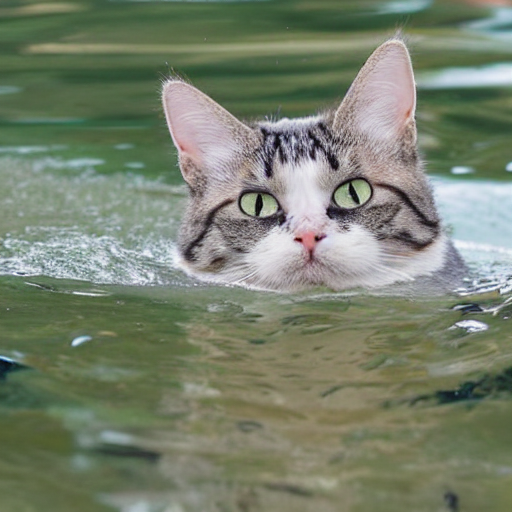

In [32]:
display(image)

## Deploy on web

We have tried to deploy the stable diffusion model with native GPU runtime. Now let’s try to deploy the stable diffusion to web end with WebGPU runtime.

To deploy to web, everything is following the same procedure. Some minor differences are:
* we need a build the model to WebGPU backend, instead of Metal backend,
* we need to implement the stable diffusion pipeline and the scheduler runtime in JavaScript.

Nevertheless, they both have the same spirit as before -- just in another form.

### Install prerequisites

We first install some prerequisite packages.

1. [emscripten](https://emscripten.org). It is an LLVM-based compiler which compiles C/C++ source code to WebAssembly.
    - Follow the [installation instruction](https://emscripten.org/docs/getting_started/downloads.html#installation-instructions-using-the-emsdk-recommended) to install the latest emsdk.
    - Source `emsdk_env.sh` by `source path/to/emsdk_env.sh`, so that `emcc` is reachable from PATH and the command `emcc` works.
2. [Rust](https://www.rust-lang.org/tools/install).
3. [`wasm-pack`](https://rustwasm.github.io/wasm-pack/installer/). It helps build Rust-generated WebAssembly, which used for tokenizer in our case here.
4. Install jekyll by following the [official guides](https://jekyllrb.com/docs/installation/). It is the package we use for website.
5. Install jekyll-remote-theme by command
    ```shell
    gem install jekyll-remote-theme
    ```
6. Install [Chrome Canary](https://www.google.com/chrome/canary/). It is a developer version of Chrome that enables the use of WebGPU.

We can run the following commands to verify that we have installed them properly and can found these programs.

In [ ]:
!emcc

In [ ]:
!jekyll

In [ ]:
!wasm-pack

After verifying the functionality of these commands, we run `scripts/prep_deps.sh` to prepare all the necessary dependencies for the web build.

In [ ]:
%%bash
export TVM_HOME=3rdparty/tvm
./scripts/prep_deps.sh

The execution `scripts/prep_deps.sh` is expected to end with
```
Copy /path/to/tvm/web/dist/tvmjs.bundle.js to dist
Copy /path/to/tvm/web/dist/wasm/tvmjs_runtime.wasi.js to dist
```

### Build the model to WebGPU backend

We now build the model to WebGPU backend and export the executable to disk in the WebAssembly file format.

In the previous section on building the model to native GPU backend, the command was
```shell
python3 build.py
```

To build to WebGPU backend, we still use `build.py`, just with an argument specifying the target:

In [ ]:
%%bash
export TVM_HOME=3rdparty/tvm
python3 build.py --target webgpu

### Set up the website

The last thing to do is setting up the site by running the following command in a terminal session:
```shell
./scripts/local_deploy_site.sh
```

Once the website is set up, open `localhost:8888/web-stable-diffusion/` in Chrome Canary to try out the demo on your local machine!

---

_Remark: don’t forget to use_
```shell
/Applications/Google\ Chrome\ Canary.app/Contents/MacOS/Google\ Chrome\ Canary --enable-dawn-features=disable_robustness
```
_to launch Chrome Canary to turn off the robustness check from Chrome._